Mehmet Umur ÖZÜ
211401025
m.ozu@etu.edu.tr

Kübra Arslan
201401024
kubraarslan@etu.edu.tr

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split


# ratings ve movies veri setini yükle
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
original_movies = movies.copy()

# Yinelenen kullanıcı-film puanlamalarını kaldır
#ratings = ratings.drop_duplicates(subset=['userId', 'movieId'], keep='last')

# Kullanıcı-film matrisi oluştur
user_movie_matrix_kmeans = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_movie_matrix_knn = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# İçerik bazlı öneri için film özellik matrisi oluştur (örneğin, tür bilgisi)
# Tür bilgilerini ayırmak ve dummy değişkenler oluşturmak için aşağıdaki kodu kullan
movies['genres'] = movies['genres'].astype(str)
movies['genres'] = movies['genres'].str.split('|')
movies_expanded = movies.explode('genres')
genre_matrix = pd.get_dummies(movies_expanded.set_index('movieId')['genres']).groupby('movieId').sum()
content_matrix = pd.get_dummies(movies_expanded.set_index('movieId')['genres']).groupby('movieId').sum()
# TF-IDF ile başlık matrisini oluşturuyoruz
tfidf = TfidfVectorizer(stop_words='english')
title_matrix = tfidf.fit_transform(movies['title'])

# Tür ve başlık matrislerini birleştiriyoruz
from scipy.sparse import hstack
combined_matrix = hstack([genre_matrix, title_matrix]).tocsr()

merged_data = ratings.merge(genre_matrix, left_on='movieId', right_index=True)


print("Veri yükleme ve işleme tamamlandı.")

Veri yükleme ve işleme tamamlandı.


In [86]:
# Eksik veri kontrolü
print("Users veri setinde eksik veri durumu:")
print(ratings.isnull().sum())  # Her sütundaki eksik değerlerin toplamı

print("\nMovies veri setinde eksik veri durumu:")
print(movies.isnull().sum())  # Her sütundaki eksik değerlerin toplamı

# Alternatif olarak, eksik veri içeren satırların toplam sayısı
print("\nUsers veri setinde eksik veri içeren satır sayısı:", ratings.isnull().any(axis=1).sum())
print("Movies veri setinde eksik veri içeren satır sayısı:", movies.isnull().any(axis=1).sum())

Users veri setinde eksik veri durumu:
userId     0
movieId    0
rating     0
dtype: int64

Movies veri setinde eksik veri durumu:
movieId    0
title      0
genres     0
dtype: int64

Users veri setinde eksik veri içeren satır sayısı: 0
Movies veri setinde eksik veri içeren satır sayısı: 0


In [87]:
from sklearn.neighbors import NearestNeighbors

# Kullanıcı bazlı collaborative filtering için
knn_user_based = NearestNeighbors(metric='cosine', algorithm='brute')
knn_user_based.fit(user_movie_matrix_knn)

# İçerik bazlı öneri için
knn_content_based = NearestNeighbors(metric='cosine', algorithm='brute')
knn_content_based.fit(combined_matrix)

print("KNN modelleri tanımlandı.")


KNN modelleri tanımlandı.


In [ ]:
from sklearn.cluster import KMeans
# Film Kümeleri: Filmlerin her birine belirli bir küme numarası atıyoruz
num_clusters = 70  # Film kümelerinin sayısını belirle
kmeans_movies = KMeans(n_clusters=num_clusters, random_state=0)
movies['cluster'] = kmeans_movies.fit_predict(combined_matrix)  # Filmlere küme numaralarını ekliyoruz

# Kullanıcı-Film Matrisini Oluştur ve Kullanıcı Kümeleri: Kullanıcılara küme numarası atıyoruz
user_movie_matrix_kmeans = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

num_user_clusters = 100  # Kullanıcı kümelerinin sayısı
kmeans_users = KMeans(n_clusters=num_user_clusters, random_state=0)
user_clusters = kmeans_users.fit_predict(user_movie_matrix_kmeans)
user_movie_matrix_kmeans['cluster'] = user_clusters  # Kullanıcıların kümelerini ekliyoruz

c:\Users\umuro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\umuro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\umuro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [ ]:
# Kullanıcı bazlı öneri
# Kullanıcı bazlı öneri
def recommend_by_user_knn(user_id, num_recommendations=6):
    user_index = user_movie_matrix_knn.index.get_loc(user_id)
    distances, indices = knn_user_based.kneighbors(user_movie_matrix_knn.iloc[user_index, :].values.reshape(1, -1), n_neighbors=num_recommendations + 1)
    
    recommended_movie_ids = []
    for i in range(1, len(distances[0])):  # İlk kullanıcı kendisi olduğu için atlıyoruz
        similar_user_index = indices[0][i]
        similar_user_id = user_movie_matrix_knn.index[similar_user_index]
        recommended_movie_ids.extend(ratings[ratings['userId'] == similar_user_id].sort_values('rating', ascending=False)['movieId'].values[:num_recommendations])
    
    return recommended_movie_ids[:num_recommendations]

# İçerik bazlı öneri
def recommend_by_content_knn(movie_id, num_recommendations=6):
    # movie_id'ye karşılık gelen `movies` veri çerçevesindeki indeksini bulalım
    movie_index = movies.index[movies['movieId'] == movie_id].tolist()[0]
    
    # KNN ile en yakın filmleri bul
    distances, indices = knn_content_based.kneighbors(combined_matrix[movie_index], n_neighbors=num_recommendations + 1)
    
    # Önerilen filmleri movies veri çerçevesinden çekelim
    recommended_movie_ids = [movies.iloc[idx]['movieId'] for idx in indices.flatten()[1:]]
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'genres']]
    return recommended_movies.reset_index(drop=True)
print("Öneri fonksiyonları tanımlandı.")

Öneri fonksiyonları tanımlandı.


In [90]:
# İçerik Tabanlı (Content-Based) Öneri Fonksiyonu
def recommend_by_content_kmeans(movie_id, num_recommendations=5):
    cluster_id = movies.loc[movies['movieId'] == movie_id, 'cluster'].values[0]
    similar_movies = movies[movies['cluster'] == cluster_id]
    return similar_movies[['movieId', 'title', 'genres']].head(num_recommendations)

# İşbirlikçi (Collaborative-Based) Öneri Fonksiyonu
def recommend_by_collaborative_kmeans(user_id, num_recommendations=5):
    user_cluster_id = user_movie_matrix_kmeans.loc[user_id, 'cluster']
    similar_users = user_movie_matrix_kmeans[user_movie_matrix_kmeans['cluster'] == user_cluster_id].index
    
    # Benzer kullanıcıların en çok puan verdiği filmleri seç
    recommended_movie_ids = []
    for similar_user_id in similar_users:
        top_movies = ratings[ratings['userId'] == similar_user_id].sort_values(by='rating', ascending=False)['movieId'].values
        recommended_movie_ids.extend(top_movies)
    
    # Eşsiz film ID'leri ve önerilen film sayısı
    recommended_movie_ids = list(set(recommended_movie_ids))[:num_recommendations]
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'genres']]
    return recommended_movies.reset_index(drop=True)
print("KMeans Clustering öneri fonksiyonları tanımlandı.")

KMeans Clustering öneri fonksiyonları tanımlandı.


In [ ]:
from sklearn.linear_model import LinearRegression
# İzlenmeyen filmler için tahmin yapma fonksiyonu
def recommend_by_linear_regression(user_id, num_recommendations):
    # Örneğin userId = 1 için kullanıcıya özel veri seti
    
    user_data = merged_data[merged_data['userId'] == user_id]

    # Modelde kullanılacak sütunları belirleyelim ve timestamp gibi gereksiz sütunları çıkaralım
    X = user_data.drop(columns=['userId', 'movieId', 'rating', 'timestamp'], errors='ignore')
    y = user_data['rating']

    # Eğitim ve test verilerini ayır
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Lineer Regresyon modelini tanımla ve eğit
    lin_reg_model = LinearRegression()
    lin_reg_model.fit(X_train, y_train)


    unwatched_movies = content_matrix[~content_matrix.index.isin(user_data['movieId'])]
    
    # Tahmin yapmadan önce, unwatched_movies'in sütunlarını X_train sütunlarına göre düzenleyelim
    unwatched_movies = unwatched_movies.reindex(columns=X_train.columns, fill_value=0)
    
    predictions = lin_reg_model.predict(unwatched_movies)
    unwatched_movies['predicted_rating'] = predictions
    recommended_movies = unwatched_movies.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    
    # Orijinal film bilgileriyle birleştir
    recommended_movies = recommended_movies.merge(movies[['movieId', 'title', 'genres']], left_index=True, right_on='movieId')
    return recommended_movies[['movieId', 'title', 'genres', 'predicted_rating']]




In [118]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# İzlenmeyen filmler için tahmin yapma fonksiyonu
def recommend_by_ridge_regression(user_id, num_recommendations):
    user_data = merged_data[merged_data['userId'] == user_id]
    X = user_data.drop(columns=['userId', 'movieId', 'rating', 'timestamp'], errors='ignore')
    y = user_data['rating']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)

    unwatched_movies = content_matrix[~content_matrix.index.isin(user_data['movieId'])]
    unwatched_movies = unwatched_movies.reindex(columns=X_train.columns, fill_value=0)
    
    predictions = ridge_model.predict(unwatched_movies)
    unwatched_movies['predicted_rating'] = predictions
    recommended_movies = unwatched_movies.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    
    recommended_movies = recommended_movies.merge(movies[['movieId', 'title', 'genres']], left_index=True, right_on='movieId')
    return recommended_movies[['movieId', 'title', 'genres', 'predicted_rating']]




In [93]:
# Belirli bir kullanıcı için kullanıcı bazlı öneriler
user_recommendations = recommend_by_user_knn(user_id=1, num_recommendations=5)
print(type(user_recommendations))
print("User-based recommendations:")
#print(user_recommendations)
print(original_movies[original_movies['movieId'].isin(user_recommendations)].to_string())

# Belirli bir film için içerik bazlı öneriler
content_recommendations = recommend_by_content_knn(movie_id=161354, num_recommendations=5)
print("Content-based recommendations:")
print(content_recommendations.to_string())


<class 'list'>
User-based recommendations:
      movieId                         title                  genres
706       924  2001: A Space Odyssey (1968)  Adventure|Drama|Sci-Fi
995      1297            Real Genius (1985)                  Comedy
996      1298   Pink Floyd: The Wall (1982)           Drama|Musical
1074     1394        Raising Arizona (1987)                  Comedy
1124     1466          Donnie Brasco (1997)             Crime|Drama
Content-based recommendations:
   movieId                                        title                      genres
0     4203  Harley Davidson and the Marlboro Man (1991)      [Action, Crime, Drama]
1     7108             Crime Story (Zhong an zu) (1993)      [Action, Crime, Drama]
2    26159      Tokyo Drifter (Tôkyô nagaremono) (1966)      [Action, Crime, Drama]
3    60979                 Batman: Gotham Knight (2008)  [Action, Animation, Crime]
4    90603                      Batman: Year One (2011)  [Action, Animation, Crime]


In [119]:
# Öneri örnekleri
content_recommendations = recommend_by_content_kmeans(movie_id=113, num_recommendations=5)
print("Content-Based KMeans Recommendations:")
print(content_recommendations.to_string())

collaborative_recommendations = recommend_by_collaborative_kmeans(user_id=1, num_recommendations=5)
print("Collaborative-Based KMeans Recommendations:")
print(collaborative_recommendations.to_string())


Content-Based KMeans Recommendations:
     movieId                                                                  title                                       genres
100      113                                                Before and After (1996)                             [Drama, Mystery]
273      314                                       Secret of Roan Inish, The (1994)          [Children, Drama, Fantasy, Mystery]
308      350                                                     Client, The (1994)                   [Drama, Mystery, Thriller]
371      427                                                   Boxing Helena (1993)          [Drama, Mystery, Romance, Thriller]
563      680  Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965)  [Drama, Mystery, Romance, Sci-Fi, Thriller]
Collaborative-Based KMeans Recommendations:
   movieId                              title                                             genres
0        1                   Toy Story (1995)  

In [120]:
# Öneri örneği
recommendations = recommend_by_linear_regression(user_id=45, num_recommendations=50)
print("Linear Regression Recommendations:")
print(recommendations.to_string())


Linear Regression Recommendations:
      movieId                                                                                                                                                 title                                                                   genres  predicted_rating
6667    57502                                                                                                                         Cat Soup (Nekojiru-so) (2001)                                    [Adventure, Animation, Drama, Horror]          5.631674
7074    69746                                                                                                         Watchmen: Tales of the Black Freighter (2009)                                   [Action, Adventure, Animation, Horror]          5.613048
6573    55167                                                                                                              Tekkonkinkreet (Tekkon kinkurîto) (2006)                           [Action, A

In [121]:
# Öneri örneği
recommendations = recommend_by_ridge_regression(user_id=45, num_recommendations=50)
print("Ridge Regression Recommendations:")
print(recommendations.to_string())


Ridge Regression Recommendations:
      movieId                                                                                                                                                 title                                                                   genres  predicted_rating
6667    57502                                                                                                                         Cat Soup (Nekojiru-so) (2001)                                    [Adventure, Animation, Drama, Horror]          5.507016
7074    69746                                                                                                         Watchmen: Tales of the Black Freighter (2009)                                   [Action, Adventure, Animation, Horror]          5.488857
6573    55167                                                                                                              Tekkonkinkreet (Tekkon kinkurîto) (2006)                           [Action, Ad

In [123]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
from sklearn.metrics import f1_score

def evaluate_user_based_model(user_id, num_recommendations=6):
    # Kullanıcının izlediği filmleri alıyoruz
    user_watched = ratings[ratings['userId'] == user_id]['movieId'].values
    user_recommendations = recommend_by_user_knn(user_id, num_recommendations)

    # Gerçek etiketleri ve tahminleri oluşturuyoruz
    y_true = np.isin(user_recommendations, user_watched).astype(int)
    y_pred = np.ones_like(y_true)

    # Precision, Recall ve F1 skorlarını hesapla
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    
    return precision, recall, f1

# Örnek olarak belirli bir kullanıcı için metrikleri ölçelim
precision, recall, f1 = evaluate_user_based_model(user_id=1, num_recommendations=6)
print(f"Precision@k: {precision:.2f}")
print(f"Recall@k: {recall:.2f}")
print(f"F1 Score@k: {f1:.2f}")


Precision@k: 0.33
Recall@k: 1.00
F1 Score@k: 0.50


In [101]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split

# Kullanıcıların izlediği filmleri test ve train olarak ayırıyoruz
def train_test_split_ratings(user_id, test_size=0.3):
    user_ratings = ratings[ratings['userId'] == user_id]
    if len(user_ratings) < 2:  # Minimum 2 rating gerekir
        return None, None
    train_ratings, test_ratings = train_test_split(user_ratings, test_size=test_size, random_state=42)
    return train_ratings['movieId'].values, test_ratings['movieId'].values

# Değerlendirme fonksiyonları
def evaluate_content_kmeans(movie_id, num_recommendations=5):
    # Belirli bir film için önerilen filmleri al
    content_recommendations = recommend_by_content_kmeans(movie_id, num_recommendations)
    recommended_movie_ids = content_recommendations['movieId'].values

    # Filmle aynı kümede yer alan ve önerilen filmleri doğru kabul edeceğiz
    cluster_id = movies.loc[movies['movieId'] == movie_id, 'cluster'].values[0]
    cluster_movies = movies[movies['cluster'] == cluster_id]['movieId'].values

    # Gerçek etiketler ve tahminler
    y_true = np.isin(recommended_movie_ids, cluster_movies).astype(int)
    y_pred = np.ones_like(y_true)
    
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    
    return precision, recall, f1

def evaluate_collaborative_kmeans(user_id, num_recommendations=5):
    # Train-test ayırımı yap
    train_movies, test_movies = train_test_split_ratings(user_id)
    if train_movies is None or test_movies is None:
        return None, None, None  # Kullanıcının yeterince verisi yoksa

    # İşbirlikçi önerileri al
    collaborative_recommendations = recommend_by_collaborative_kmeans(user_id, num_recommendations)
    recommended_movie_ids = collaborative_recommendations['movieId'].values

    # Test setindeki filmleri doğru kabul ediyoruz
    y_true = np.isin(recommended_movie_ids, test_movies).astype(int)
    y_pred = np.ones_like(y_true)
    
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    
    return precision, recall, f1



collab_precision, collab_recall, collab_f1 = evaluate_collaborative_kmeans(user_id=1, num_recommendations=5)
if collab_precision is not None:
    print(f"Collaborative-Based KMeans Recommendations - Precision@5: {collab_precision:.2f}, Recall@5: {collab_recall:.2f}, F1 Score@5: {collab_f1:.2f}")
else:
    print("Collaborative-Based KMeans Recommendations: User does not have enough data.")


Collaborative-Based KMeans Recommendations - Precision@5: 0.20, Recall@5: 1.00, F1 Score@5: 0.33


In [117]:
#lineer regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
def calculate_errors_for_all_users(num_recommendations=50):
    users = ratings['userId'].unique()
    mae_list = []
    rmse_list = []
    for user_id in users:
        # Kullanıcıya özel veri seti oluşturma
        user_data = merged_data[merged_data['userId'] == user_id]
        
        # Modelde kullanılacak sütunları belirleyelim
        X = user_data.drop(columns=['userId', 'movieId', 'rating', 'timestamp'], errors='ignore')
        y = user_data['rating']
        
        # Eğitim ve test verilerini ayır
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Lineer Regresyon modelini tanımla ve eğit
        lin_reg_model = LinearRegression()
        lin_reg_model.fit(X_train, y_train)
        
        # Kullanıcının izlemediği filmleri al
        unwatched_movies = content_matrix[~content_matrix.index.isin(user_data['movieId'])]
        
        # Tahmin için unwatched_movies'i düzenle
        unwatched_movies = unwatched_movies.reindex(columns=X_train.columns, fill_value=0)
        
        # Tahmin yap
        predictions = lin_reg_model.predict(unwatched_movies)
        
        # En iyi tahmin edilen filmleri seçme
        unwatched_movies['predicted_rating'] = predictions
        recommended_movies = unwatched_movies.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
        
        # Gerçek ve tahmin edilen puanları karşılaştırma
        y_true = y_test  # Gerçek test setindeki puanlar
        y_pred = lin_reg_model.predict(X_test)  # Test seti üzerinden tahmin edilen puanlar
        
        # Hata metriklerini hesaplama
        mae_list.append(mean_absolute_error(y_true, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    # Tüm kullanıcılar için ortalama MAE ve RMSE
    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)

    return avg_mae, avg_rmse


# Tüm kullanıcılar için ortalama hata metriklerini hesapla
avg_mae, avg_rmse = calculate_errors_for_all_users(num_recommendations=50)
print(f"Average MAE: {avg_mae}")
print(f"Average RMSE: {avg_rmse}")


Average MAE: 0.9173209286530466
Average RMSE: 1.1499990809725567


In [116]:
# Tüm kullanıcılar için ridge ortalama hata metriklerini hesapla
def calculate_errors_for_all_users2(num_recommendations=50):
    users = ratings['userId'].unique()
    mae_list = []
    rmse_list = []
    for user_id in users:
        user_data = merged_data[merged_data['userId'] == user_id]
        X = user_data.drop(columns=['userId', 'movieId', 'rating', 'timestamp'], errors='ignore')
        y = user_data['rating']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(X_train, y_train)
        
        y_pred = ridge_model.predict(X_test)
        
        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    return avg_mae, avg_rmse

avg_mae, avg_rmse = calculate_errors_for_all_users2(num_recommendations=50)
print(f"Average MAE: {avg_mae}")
print(f"Average RMSE: {avg_rmse}")



Average MAE: 0.7647954614843775
Average RMSE: 0.9490071171756419


For k=1: Precision@5: 0.00, Recall@5: 1.00, F1 Score@5: 0.00
For k=2: Precision@5: 0.00, Recall@5: 1.00, F1 Score@5: 0.00
For k=3: Precision@5: 0.00, Recall@5: 1.00, F1 Score@5: 0.00
For k=4: Precision@5: 0.25, Recall@5: 1.00, F1 Score@5: 0.40
For k=5: Precision@5: 0.20, Recall@5: 1.00, F1 Score@5: 0.33
For k=6: Precision@5: 0.33, Recall@5: 1.00, F1 Score@5: 0.50
For k=7: Precision@5: 0.29, Recall@5: 1.00, F1 Score@5: 0.44
For k=8: Precision@5: 0.25, Recall@5: 1.00, F1 Score@5: 0.40
For k=9: Precision@5: 0.22, Recall@5: 1.00, F1 Score@5: 0.36
For k=10: Precision@5: 0.20, Recall@5: 1.00, F1 Score@5: 0.33


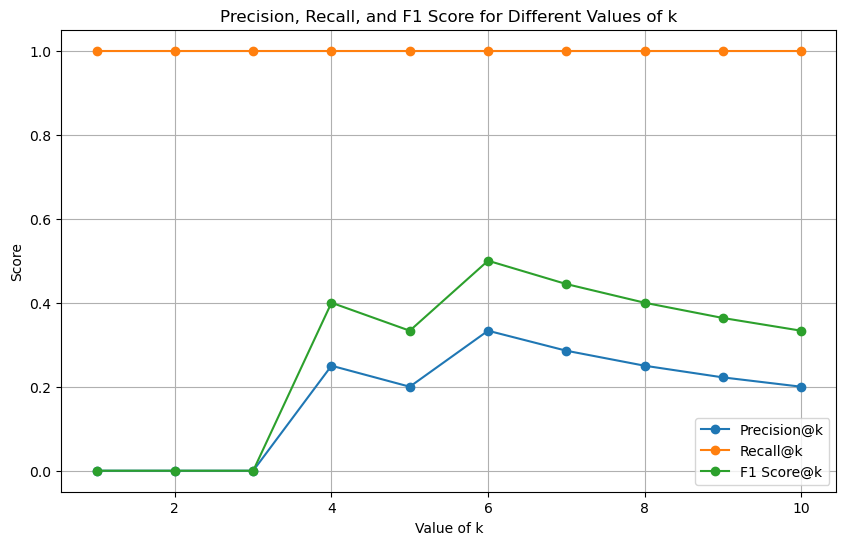

In [ ]:
import matplotlib.pyplot as plt
#For KNN
# Calculate metrics for different values of k
k_values = range(1, 11)
precision_scores = []
recall_scores = []
f1_scores = []

for k in k_values:
    precision, recall, f1 = evaluate_user_based_model(user_id=1, num_recommendations=k)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    print(f"For k={k}: Precision@5: {precision:.2f}, Recall@5: {recall:.2f}, F1 Score@5: {f1:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_scores, label='Precision@k', marker='o')
plt.plot(k_values, recall_scores, label='Recall@k', marker='o')
plt.plot(k_values, f1_scores, label='F1 Score@k', marker='o')
plt.xlabel("Value of k")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score for Different Values of k")
plt.legend()
plt.grid()
plt.show()

c:\Users\umuro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for k=40: 14091.63
Inertia for k=41: 14048.00
Inertia for k=42: 14020.13
Inertia for k=43: 13969.28
Inertia for k=44: 13925.92
Inertia for k=45: 13767.07
Inertia for k=46: 13874.29
Inertia for k=47: 13682.35
Inertia for k=48: 13706.27
Inertia for k=49: 13739.31
Inertia for k=50: 13610.42
Inertia for k=51: 13631.97
Inertia for k=52: 13499.61
Inertia for k=53: 13486.42
Inertia for k=54: 13462.73
Inertia for k=55: 13396.60
Inertia for k=56: 13386.91
Inertia for k=57: 13286.87
Inertia for k=58: 13262.65
Inertia for k=59: 13152.75
Inertia for k=60: 13079.67
Inertia for k=61: 13179.29
Inertia for k=62: 13187.74
Inertia for k=63: 13071.14
Inertia for k=64: 13101.11
Inertia for k=65: 13010.84
Inertia for k=66: 12994.38
Inertia for k=67: 12956.53
Inertia for k=68: 12883.92
Inertia for k=69: 12945.91
Inertia for k=70: 12882.35


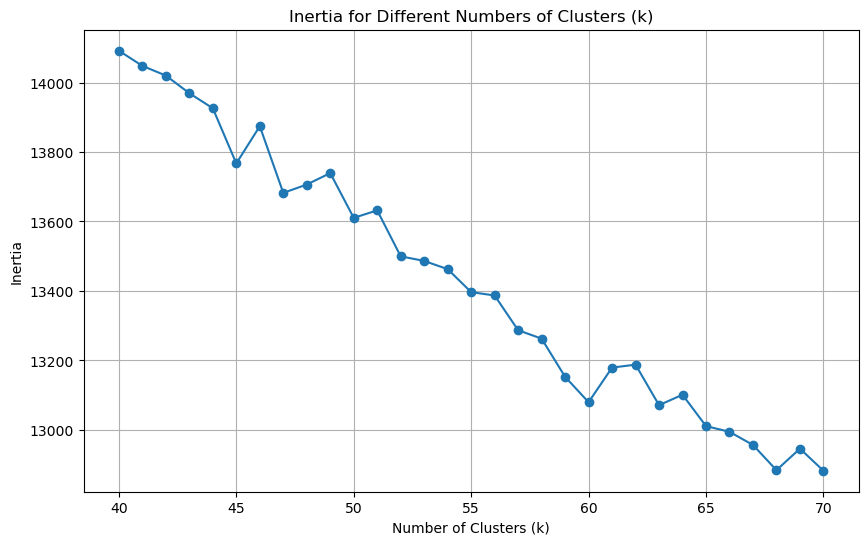

In [112]:
def calculate_inertia_for_different_k(data, min_k = 1, max_k=10):
    inertia_values = []
    k_values = range(min_k, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        print(f"Inertia for k={k}: {kmeans.inertia_:.2f}")  # Her k için inertia değerini yazdırıyoruz

    return k_values, inertia_values

k_values, inertia_values = calculate_inertia_for_different_k(combined_matrix, min_k = 40,max_k=70)

# Grafiği çizdirme
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Inertia for Different Numbers of Clusters (k)")
plt.grid()
plt.show()


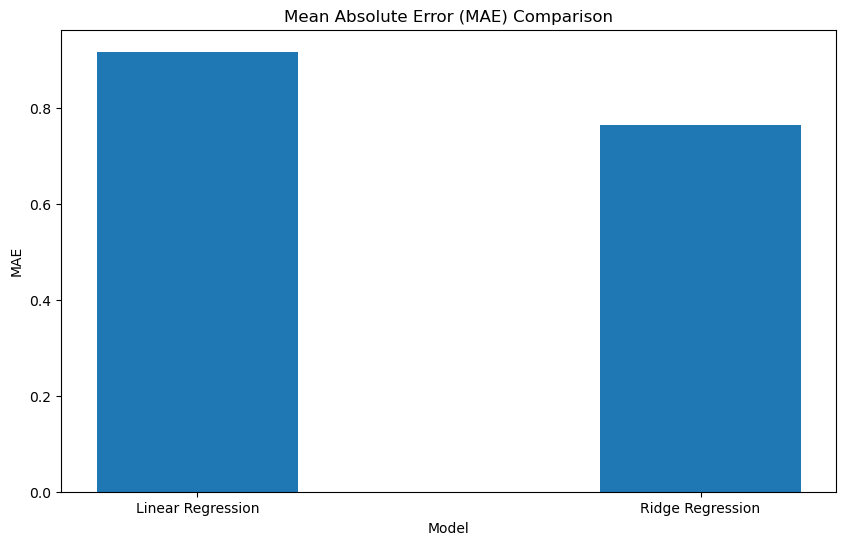

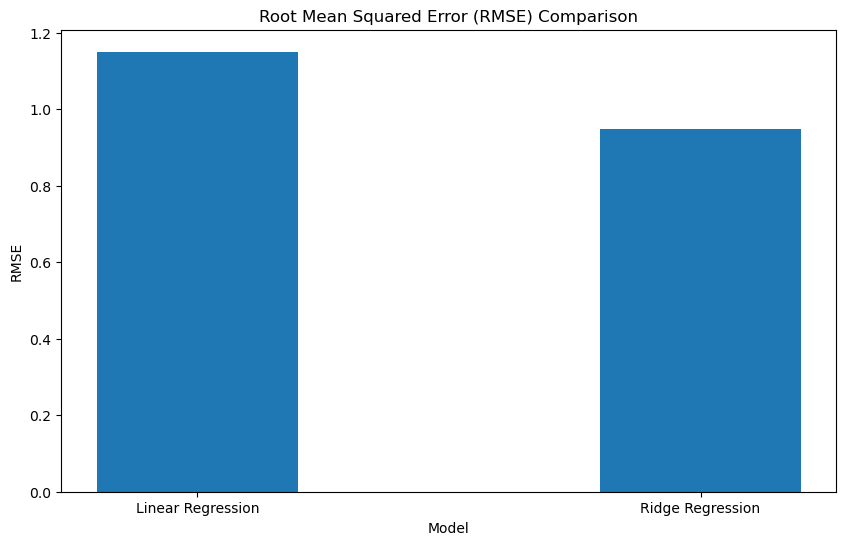

In [108]:
import matplotlib.pyplot as plt

# Data for MAE and RMSE values for Linear and Ridge regression
models = ['Linear Regression', 'Ridge Regression']
mae_values = [0.9173209286530466, 0.7647954614843775]
rmse_values = [1.1499990809725567, 0.9490071171756419]

# Plotting MAE comparison
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, width=0.4)
plt.title("Mean Absolute Error (MAE) Comparison")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.show()

# Plotting RMSE comparison
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, width=0.4)
plt.title("Root Mean Squared Error (RMSE) Comparison")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.show()
